## Shuttle Fullness Experiment
predicting shuttle fullness using south campus parking garage data.

ideas:
- ~~take derivative of south campus parking garage data to find when parking garage is increasing most rapidly~~
- create a heuristic between rate of how fast south campus fills up to shuttle fullness (i.e. highest value on derivative is bus is full, every value takes a portion of that)

polished idea:
- calculate slope of current point with first point that is more than 15 mins behind. calculate slope between this point and current point. heuristic is 1% = 5 people. so a 5% increase in ~15 mins means 25 people have entered the parking garage in the last 15 mins. 25 people will be output for how long the shuttle line is. Positive slopes are lines at the alma stop, negative slopes are lines at the duncan hall spot.

In [44]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
import os
import sys
from dotenv import load_dotenv
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load .env file
load_dotenv()

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))

from data_load import load_week_data

In [45]:
DATE_START = "" 
DATE_END =  ""
GARAGE = "South Campus Garage"

def convert_pd_to_list(garage_data_by_week):
    # normalize all values in dfs to populate x_data and y_data
    x_data = []
    y_data = []
    start_dates = []
    ind = 0
    for df in garage_data_by_week:
        mon_to_thurs = df[df['timestamp'].dt.weekday != 4]
        ts = mon_to_thurs["timestamp"].iloc[0]
        start_dates.append(ts)
        monday = ts - pd.Timedelta(days=ts.weekday())
        monday = monday.replace(hour=0, minute=0, second=0, microsecond=0)

        x_data.append(((mon_to_thurs["timestamp"] - monday).dt.total_seconds() / 60).values)
        y_data.append(mon_to_thurs["fullness"].values)
        ind += 1
    return (x_data, y_data, start_dates)

start_dates, end_dates, week_data_by_garage = load_week_data()

x, y, start_dates = convert_pd_to_list(week_data_by_garage[GARAGE])

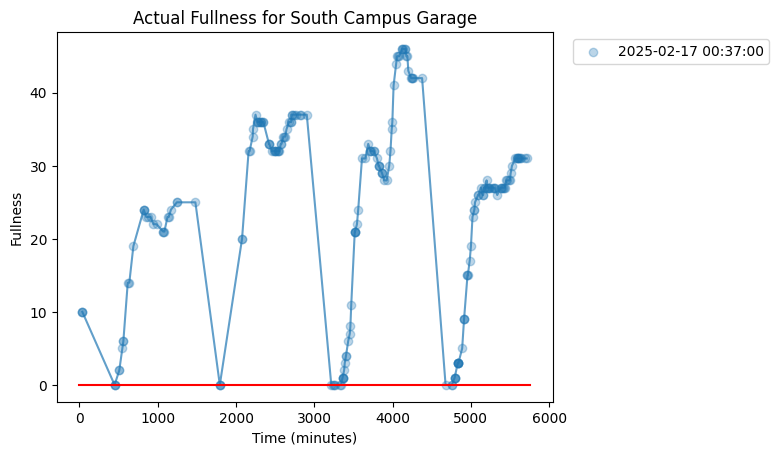

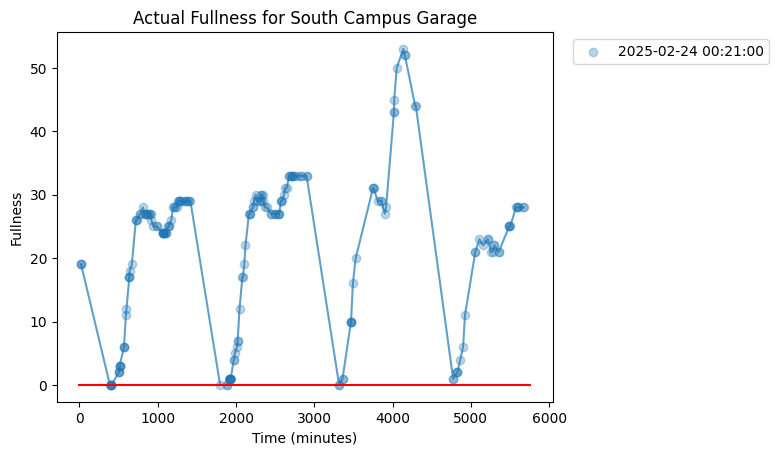

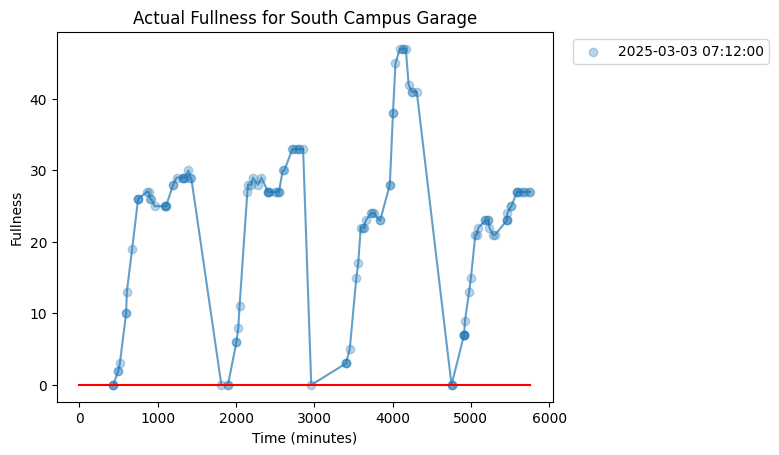

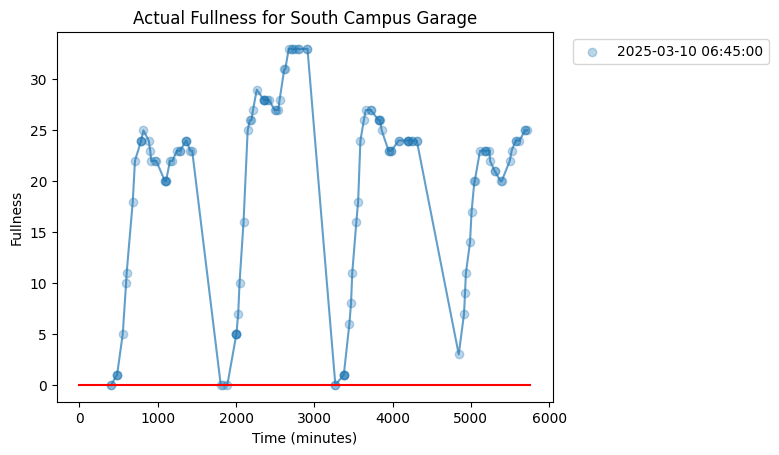

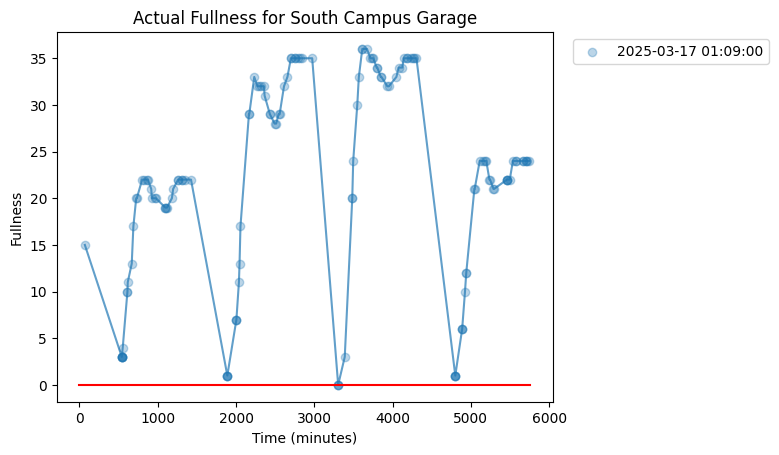

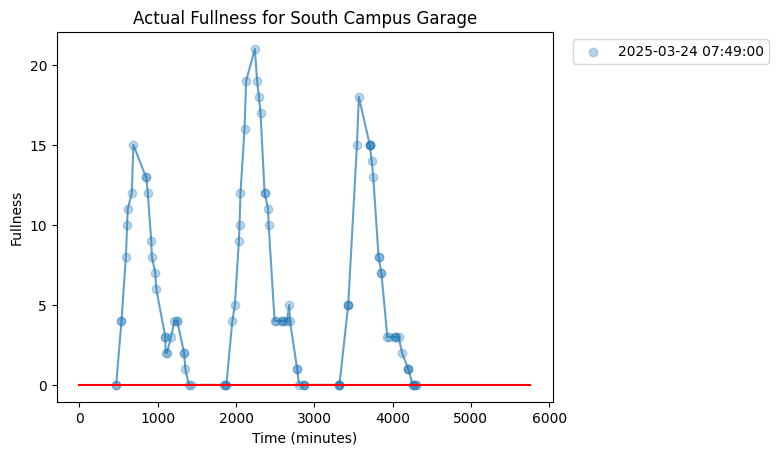

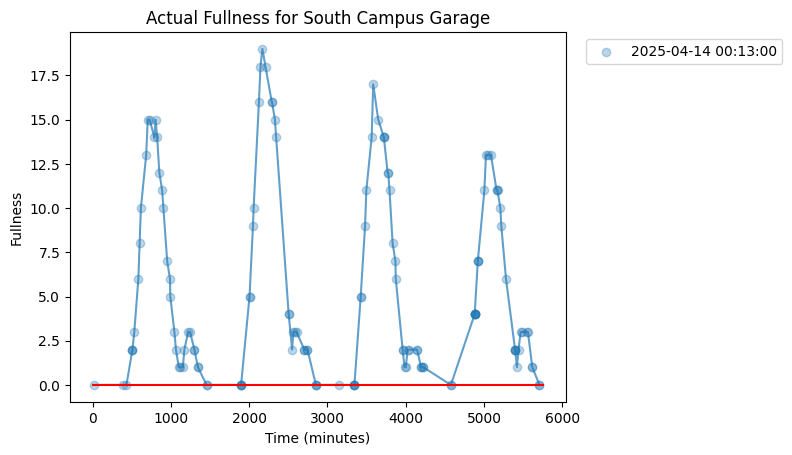

In [46]:
def make_plot(x, y, start_dates):
    for i in range(len(x)):
        plt.scatter(x[i], y[i], alpha=0.3, label=f'{start_dates[i]}')
        plt.plot(x[i], y[i], alpha=0.7)

    # generate x_stream from start of monday to end of thursday
    x_end = pd.Timedelta(days=4).total_seconds() / 60
    all_x_vals = np.linspace(0, x_end, num=1000)

    all_y_vals = np.zeros_like(all_x_vals)
    plt.plot(all_x_vals, all_y_vals, color='red')

    plt.xlabel('Time (minutes)')
    plt.ylabel('Fullness')
    plt.title(f'Actual Fullness for {GARAGE}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
    plt.show()

def choose_one_week(x, y, start_dates, week_index):
    x_week = [x[week_index]]
    y_week = [y[week_index]]
    start_dates_copy = [start_dates[week_index]]
    make_plot(x_week, y_week, start_dates_copy)

for i in range(1, len(start_dates)):
    choose_one_week(x, y, start_dates, i)

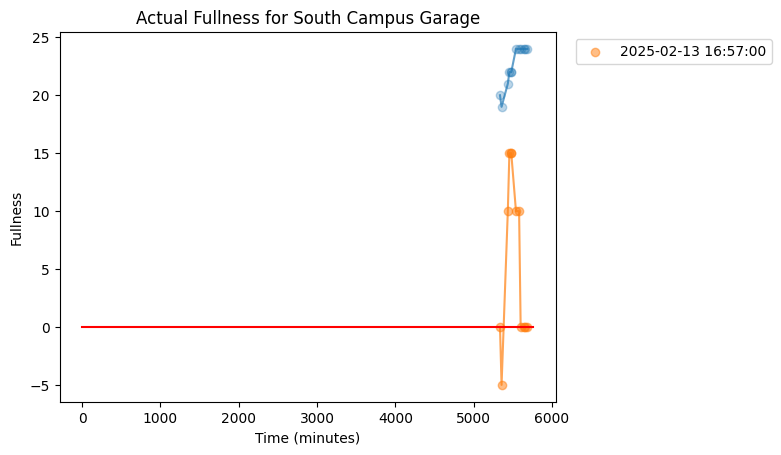

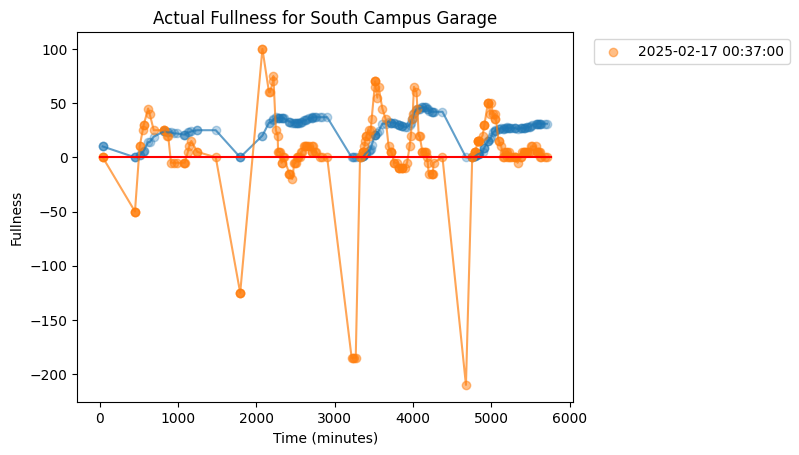

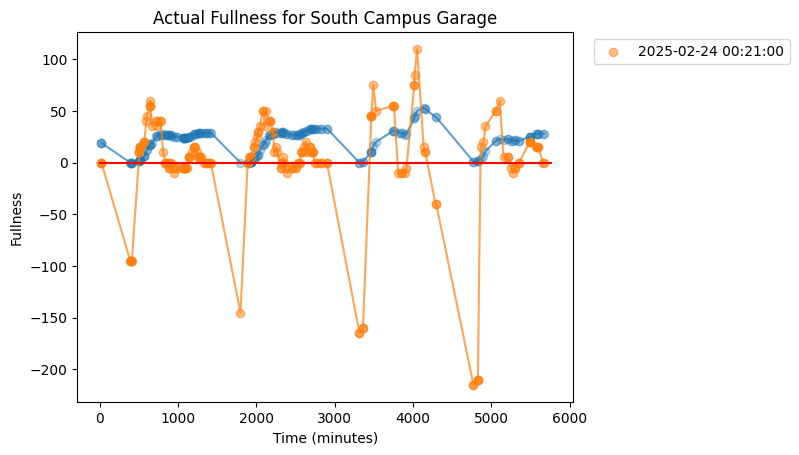

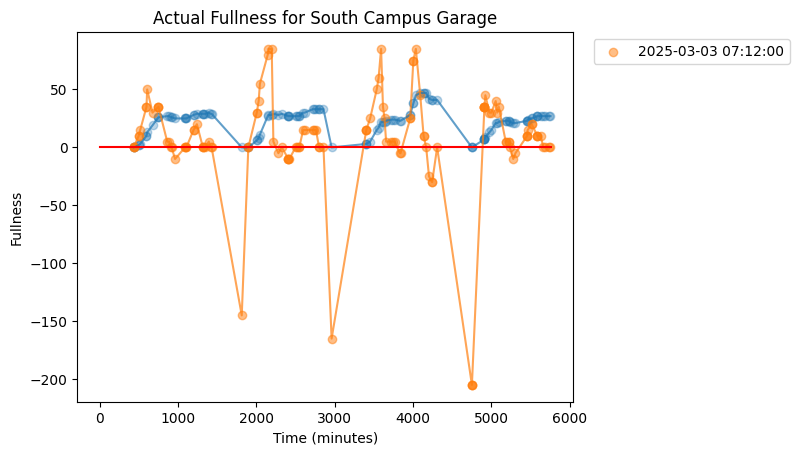

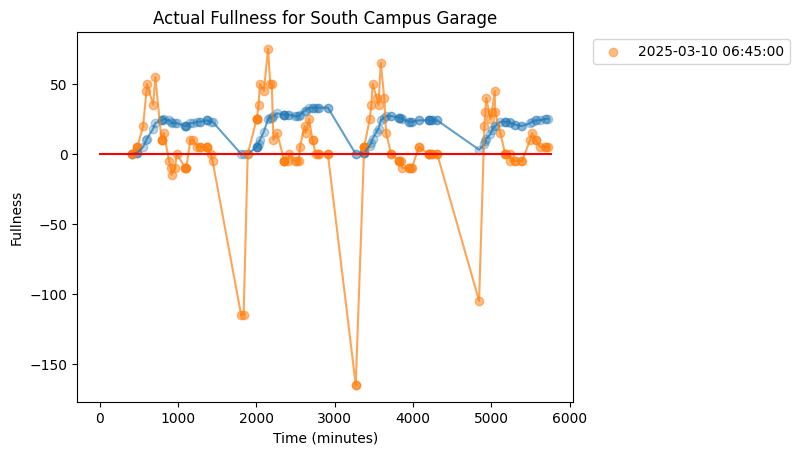

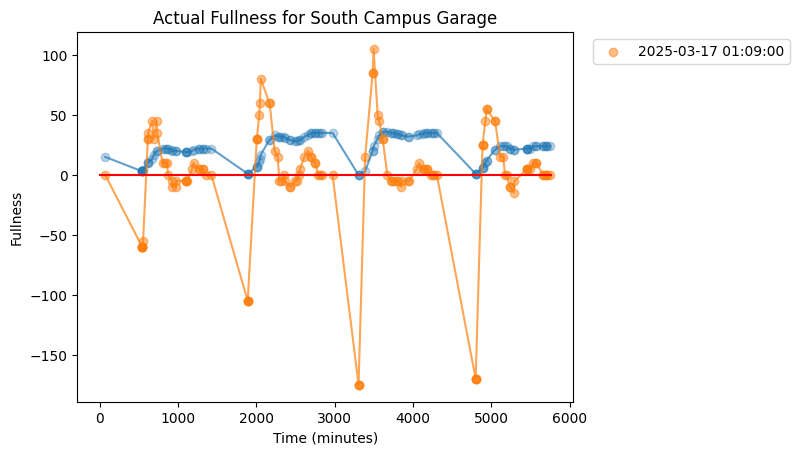

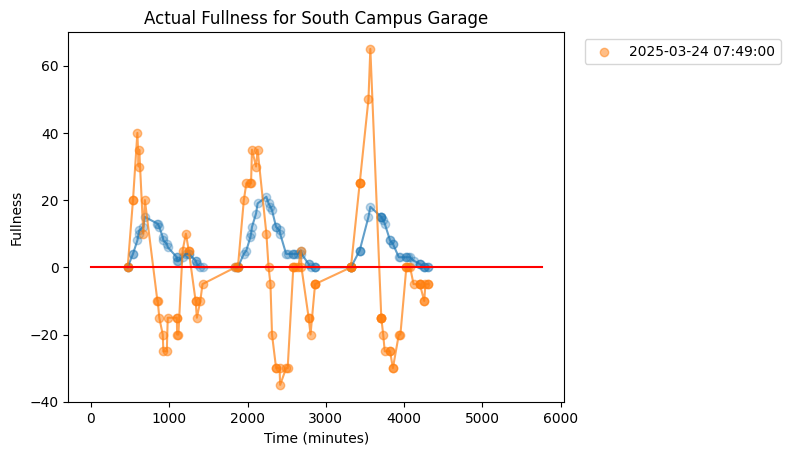

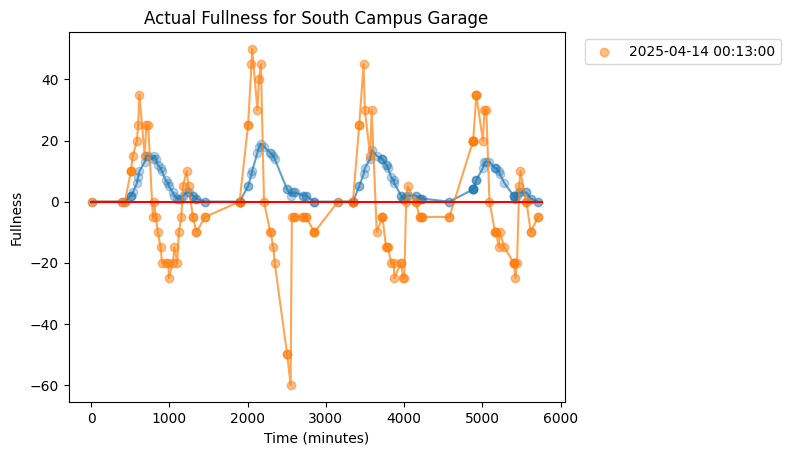

In [63]:
TIME_BEFORE = 60 # minutes
HEURISTIC_MULTIPLIER = 5 # 1% = 5 people

# create a stream for all points, for every point take closest point 15 mins behind and calculate slope

def plot_predictions(x, y, pred_y, start_date):
    # raw data
    plt.scatter(x, y, alpha=0.3)
    plt.plot(x, y, alpha=0.7)

    # predicted slope data
    plt.scatter(x, pred_y, alpha=0.5, label=f'{start_date}')
    plt.plot(x, pred_y, alpha=0.7)

    # generate x_stream from start of monday to end of thursday
    x_end = pd.Timedelta(days=4).total_seconds() / 60
    all_x_vals = np.linspace(0, x_end, num=1000)

    all_y_vals = np.zeros_like(all_x_vals)
    plt.plot(all_x_vals, all_y_vals, color='red')

    plt.xlabel('Time (minutes)')
    plt.ylabel('Fullness')
    plt.title(f'Actual Fullness for {GARAGE}')
    plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
    plt.show()

# calculating predictions/slopes
weeks = len(start_dates)

for week in range(weeks):
    x_week = x[week]
    y_week = y[week]
    start_date = start_dates[week]
    pred_y = [0]

    # create predictions list
    for ind in range(1, len(x_week)): # iterating week_indices indices
        orig_ind = ind
        while ind >= 0 and x_week[ind] > (x_week[orig_ind] - TIME_BEFORE):
            ind -= 1
        if ind < 0:
            ind = 0
        y_change = y_week[orig_ind] - y_week[ind] # represents change in percentage fullness in TIME_BEFORE minutes
        pred_y.append(y_change * HEURISTIC_MULTIPLIER)

    plot_predictions(x_week, y_week, pred_y, start_date)